# Programming Assignment #3: Convolutional Networks
Author: Pierre Nugues

<h2>Objectives</h2>

The objectives of this assignment are to:
* Write a program to recognize flowers on images
* Learn how to manage an image data set
* Apply convolutional networks to images
* Know what Python generators are
* Understand class activation
* Write a short report on your experiments. This report is mandatory to pass the assignment.

## Organization

Each group will have to:
* Write Python programs to recognize the sort of flower in an image.
* Experiment different neural architectures and compare the results.

Each student will have to:
* Run at home Chollet's notebook: `5.4-visualizing-what-convnets-learn.ipynb` (https://github.com/fchollet/deep-learning-with-python-notebooks)
* Write an individual report on these experiments.

While not compulsory, I highly recommend that you use Google colab and run your program on a GPU. This is something you select when you run the notebook (runtime type). You will have to create a Google account for this: https://colab.research.google.com

As there are a few parameterization steps, I recommend that you start this lab as early as you can.

## Collecting a Dataset

1. You will collect a dataset from Kaggle (https://www.kaggle.com/). First register, it is free, and you will have access to lots of datasets.
2. Download the Flower corpus (https://www.kaggle.com/alxmamaev/flowers-recognition). You can find a local copy in the `/usr/local/cs/EDAN95/datasets` folder.
3. Split randomly your dataset into training, validation, and test sets: Use a 60/20/20 ratio. You will read all the file names and create a list of pairs, (file_name, category). You will then shuffle your list and save your partition of the data. To speed up the lab, you can also:
 * Start with the partition available in the `/usr/local/cs/EDAN95/datasets` folder; or
 * You can also run the code in the cells below (recommended).


In [1]:
import os
import random
import shutil
from tqdm import tqdm

# The machine name
machine_name = 'pierre'

# To create the same dataset
random.seed(0)

If you use Google colab (recommended). Use the GPU accelerator

In [2]:
if machine_name == 'colab':
    from google.colab import drive
    drive.mount("/content/drive")

In [ ]:
# Here write the path to your dataset
if machine_name == 'vilde':
    base = '/home/pierre/Cours/EDAN95/datasets/'
elif machine_name == 'pierre':
    base = '/Users/pierre/Documents/Cours/EDAN95/datasets/'
elif machine_name == 'colab': # If you run your notebook with colab
    base = '/content/drive/My Drive/Colab Notebooks/'
else: # If you run your notebook on your machine
    base = 'your folder'

In [3]:
original_dataset_dir = os.path.join(base, 'flowers')
dataset = os.path.join(base, 'flowers_split')

train_dir = os.path.join(dataset, 'train')
validation_dir = os.path.join(dataset, 'validation')
test_dir = os.path.join(dataset, 'test')

categories = os.listdir(original_dataset_dir)
categories = [category for category in categories if not category.startswith('.')]
print('Image types:', categories)
data_folders = [os.path.join(original_dataset_dir, category) for category in categories]
data_folders

Image types: ['daisy', 'rose', 'tulip', 'dandelion', 'sunflower']


['/Users/pierre/Documents/Cours/EDAN95/datasets/flowers/daisy',
 '/Users/pierre/Documents/Cours/EDAN95/datasets/flowers/rose',
 '/Users/pierre/Documents/Cours/EDAN95/datasets/flowers/tulip',
 '/Users/pierre/Documents/Cours/EDAN95/datasets/flowers/dandelion',
 '/Users/pierre/Documents/Cours/EDAN95/datasets/flowers/sunflower']

We build the (image, label) pairs

In [4]:
pairs = []
for folder, category in zip(data_folders, categories):
    images = os.listdir(folder)
    images = [image for image in images if not image.startswith('.')]
    pairs.extend([(image, category) for image in images])
pairs[:10]

[('14167534527_781ceb1b7a_n.jpg', 'daisy'),
 ('34718882165_68cdc9def9_n.jpg', 'daisy'),
 ('5512287917_9f5d3f0f98_n.jpg', 'daisy'),
 ('476857510_d2b30175de_n.jpg', 'daisy'),
 ('521762040_f26f2e08dd.jpg', 'daisy'),
 ('33837577463_1ae52a3726_n.jpg', 'daisy'),
 ('34638378196_216d5bbc2e_n.jpg', 'daisy'),
 ('7320089276_87b544e341.jpg', 'daisy'),
 ('8008258043_5457dd254b_n.jpg', 'daisy'),
 ('721595842_bacd80a6ac.jpg', 'daisy')]

We define a split. We will run this part only once to create the partition into training, validation, and test sets.

In [5]:
if not os.path.isdir(dataset):
    random.shuffle(pairs)
    img_nbr = len(pairs)
    train_images = pairs[0:int(0.6 * img_nbr)]
    val_images = pairs[int(0.6 * img_nbr):int(0.8 * img_nbr)]
    test_images = pairs[int(0.8 * img_nbr):]

    # print(train_images)
    print(len(train_images))
    print(len(val_images))
    print(len(test_images))

2595
865
866


We create the three subsets. We will run this part only once to create the partition into training, validation, and test sets.

In [6]:
if not os.path.isdir(dataset):
    for image, label in tqdm(train_images):
        src = os.path.join(original_dataset_dir, label, image)
        dst = os.path.join(train_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)

    for image, label in tqdm(val_images):
        src = os.path.join(original_dataset_dir, label, image)
        dst = os.path.join(validation_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)

    for image, label in tqdm(test_images):
        src = os.path.join(original_dataset_dir, label, image)
        dst = os.path.join(test_dir, label, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(src, dst)

100%|██████████| 866/866 [00:00<00:00, 2525.55it/s]


## Building a Simple Convolutional Neural Network

### Architecture

Create a simple convolutional network and train a model with the train set. You can start from the architecture proposed by Chollet, Listing 5.5 (in Chollet's notebook 5.2), and a small number of epochs. Use the `ImageDataGenerator` class to scale your images as in the book:
```
train_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)
```
* You will need to modify some parameters so that your network handles multiple classes.
* You will also adjust the number of steps so that your generator in the fitting procedure sees all the samples.
* You will report the training and validation losses and accuracies and comment on the possible overfit.

In [7]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

EPOCHS = 30
OPTIMIZER = 'rmsprop'
# The pretrained network
PRETRAINED = 'INCEPTION'

Create the network and compile it

In [ ]:
# Write your code here


Create now the data generators for the training, validation, and test set

In [9]:
# Write your code here


Found 2593 images belonging to 5 classes.
Found 865 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


Compute `STEPS_PER_EPOCH` and `VALIDATION_STEPS`

In [10]:
# Write your code here


And fit your model

In [ ]:
# Write your code here


### Analyzing the fitting performance over epochs

As in Chollet's examples, print the training and validation loss

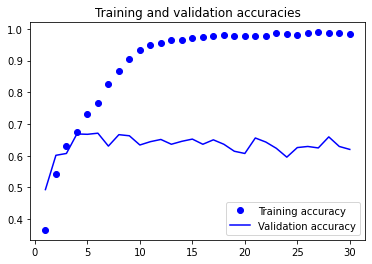

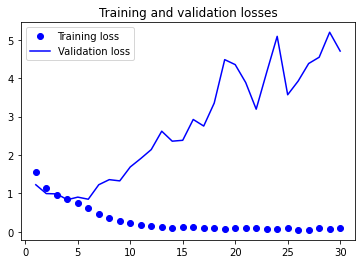

In [12]:
# Write your code here


### Predicting the test set

Apply now your network to the test set

In [13]:
# Write your code here


Report the accuracy as well as the classification report. Use sklearn functions

In [14]:
# Write your code here


Simple CNN
Class indices {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}
sklearn accuracy: 0.6947976878612717
Classification report:
              precision    recall  f1-score   support

           0       0.66      0.77      0.71       175
           1       0.77      0.76      0.77       203
           2       0.56      0.63      0.59       158
           3       0.84      0.66      0.74       140
           4       0.69      0.63      0.66       189

    accuracy                           0.69       865
   macro avg       0.71      0.69      0.69       865
weighted avg       0.70      0.69      0.70       865



Print the confusion matrix

In [15]:
# Write your code here


Confusion matrix
[[134  14  15   2  10]
 [ 23 155   9   7   9]
 [ 17  12 100   3  26]
 [ 20  10  10  92   8]
 [  8  11  45   5 120]]


Finally, run a model evaluation and store the loss and accuracy in the `test_loss_1` and `test_acc_1` variables. As with fitting, you may need to adjust the number of steps so that your network tests all the samples.

In [16]:
# Write your code here

865/865 [==============================] - 14s 16ms/step - loss: 4.0411 - acc: 0.6948
Epochs 30
loss 4.041093349456787 test acc: 0.694797694683075


Try to improve your model by modifying some parameters and evaluate your network again.

## Using Image Augmentation

### Architecture

The flower dataset is relatively small. A way to expand such datasets is to generate artificial images by applying small transformations to existing images. Keras provides a built-in class for this: `ImageDataGenerator`. You will reuse it and apply it to the flower data set.
1. Using the network from the previous exercise, apply some transformations to your images. You can start from Chollet, Listing 5.11 (in notebook 5.2 also).
2. Report the training and validation losses and accuracies and comment on the possible overfit.
3. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.


Write a new generator for the training set

In [17]:
# Write your code here


Fit a model. You reset the model by recreating it.

In [ ]:
# Write your code here


### Analyzing the fitting performance over epochs

Show the training accuracy along with the epochs

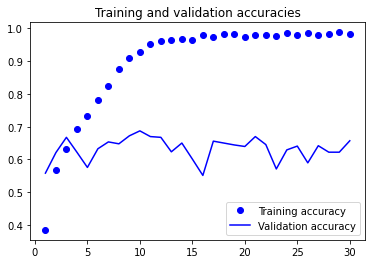

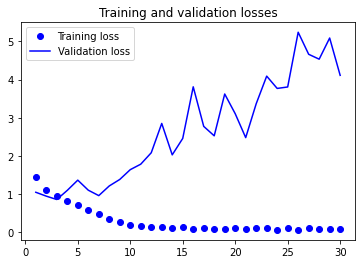

In [19]:
# Write your code here


### Predicting the test set

Finally, run a model evaluation and store the loss and accuracy in the `test_loss_2` and `test_acc_2` variables.

In [20]:
# Write your code here


865/865 [==============================] - 13s 15ms/step - loss: 3.5375 - acc: 0.6844
Epochs 30
loss 3.537476062774658 test acc: 0.684393048286438


## Using a Pretrained Convolutional Base

### Architecture

Some research teams have trained convolutional neural networks on much larger datasets. We have seen during the lecture that the networks can model conceptual patterns as they go through the layers. This was identified by Le Cun in his first experiments [http://yann.lecun.com/exdb/lenet/](http://yann.lecun.com/exdb/lenet/). In this last part, you will train classifiers on top of a pretrained convolutional base.
1. Train your network and report the training and validation losses and accuracies.
2. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.

In [21]:
from keras.applications import VGG16, InceptionV3

In [22]:
if PRETRAINED == 'VGG':
    conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
else:
    conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d_8[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

As in Chollet, Listing 5.17 (in Chollet's notebook 5.3), you will program an `extract_features()` function.

In [23]:
# Write your code


The features and labels

In [24]:
train_features, train_labels = extract_features(train_dir, BATCH_SIZE_TRAIN)
validation_features, validation_labels = extract_features(validation_dir, BATCH_SIZE_VAL)
test_features, test_labels = extract_features(test_dir, BATCH_SIZE_TEST)

  0%|          | 0/130 [00:00<?, ?it/s]

Found 2593 images belonging to 5 classes.


  0%|          | 0/44 [00:00<?, ?it/s]

Found 865 images belonging to 5 classes.


  0%|          | 3/865 [00:00<00:39, 21.56it/s]

Found 865 images belonging to 5 classes.


100%|██████████| 865/865 [00:46<00:00, 18.48it/s]


In [25]:
train_features = np.reshape(train_features, (train_features.shape[0], np.prod(train_features.shape[1:])))  # (2593, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (validation_features.shape[0], np.prod(validation_features.shape[1:]))) # (865, 4 * 4 * 512)
test_features = np.reshape(test_features, (test_features.shape[0], np.prod(test_features.shape[1:]))) # (865, 4 * 4 * 512))

Build a network that consists of the Inception V3 convolutional base and two dense layers.

In [ ]:
# Write your code


Fit your network

In [27]:
# Write your code


Epoch 1/30
130/130 [==============================] - 4s 34ms/step - loss: 5.1645 - acc: 0.5499 - val_loss: 0.7594 - val_acc: 0.7225
Epoch 2/30
130/130 [==============================] - 4s 33ms/step - loss: 1.2365 - acc: 0.6645 - val_loss: 0.7124 - val_acc: 0.7595
Epoch 3/30
130/130 [==============================] - 4s 33ms/step - loss: 1.0036 - acc: 0.7104 - val_loss: 0.8477 - val_acc: 0.7584
Epoch 4/30
130/130 [==============================] - 4s 33ms/step - loss: 0.8034 - acc: 0.7497 - val_loss: 0.8852 - val_acc: 0.7780
Epoch 5/30
130/130 [==============================] - 4s 33ms/step - loss: 0.8422 - acc: 0.7682 - val_loss: 0.6786 - val_acc: 0.8058
Epoch 6/30
130/130 [==============================] - 4s 33ms/step - loss: 0.8270 - acc: 0.7879 - val_loss: 0.8303 - val_acc: 0.7815
Epoch 7/30
130/130 [==============================] - 4s 32ms/step - loss: 0.6868 - acc: 0.8157 - val_loss: 0.6732 - val_acc: 0.8000
Epoch 8/30
130/130 [==============================] - 4s 33ms/step - 

### Analyzing the fitting performance over epochs

Show the training accuracy along with the epochs

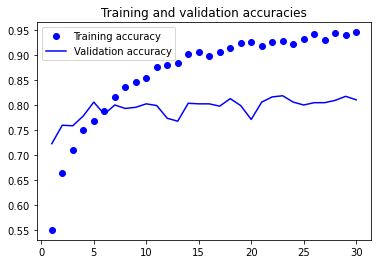

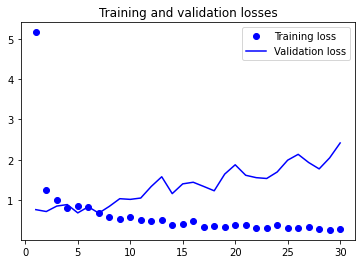

In [28]:
# Write your code here


### Predicting the test set

Apply now your network to the test set

In [29]:
# Write your code here


Report the accuracy as well as the classification report. Use sklearn functions

In [30]:
# Write your code here


Pretrained CNN VGG
Classification report
              precision    recall  f1-score   support

           0       0.93      0.77      0.84       175
           1       0.82      0.91      0.86       203
           2       0.88      0.73      0.80       158
           3       0.81      0.86      0.83       140
           4       0.77      0.88      0.82       189

    accuracy                           0.83       865
   macro avg       0.84      0.83      0.83       865
weighted avg       0.84      0.83      0.83       865



Print the confusion matrix

In [31]:
# Write your code here


Confusion matrix
[[134  18   4  10   9]
 [  5 185   1   5   7]
 [  2   4 115   6  31]
 [  2  12   3 120   3]
 [  1   7   8   7 166]]


Finally, run a model evaluation and store the loss and accuracy in the `test_loss_3` and `test_acc_3` variables. As with fitting, you may need to adjust the number of steps so that your network tests all the samples.

In [32]:
# Write your code here


28/28 [==============================] - 0s 3ms/step - loss: 1.9510 - acc: 0.8324
Epochs 30
loss 1.950987696647644 test acc: 0.8323699235916138


## Using a Pretrained Convolutional Base with Image Augmentation

### Architecture

1. Modify your program to include an image transformer. Train a new model. As a hint, you can make the whole convolutional base trainable and use the stochastic gradient descent as optimizer.
2. Apply your network to the test set and report the accuracy as well as the confusion matrix you obtained.

In [33]:
if PRETRAINED == 'VGG':
    conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
else:
    conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_102 (Conv2D)             (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_102[0][0]                 
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [ ]:
# Write you code


Create the generators

In [35]:
# Write your code


Found 2593 images belonging to 5 classes.
Found 865 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


Fit the model

In [36]:
# Write your code


Epoch 1/30
129/129 - 115s - loss: 0.9898 - acc: 0.6183 - val_loss: 0.6705 - val_acc: 0.7581
Epoch 2/30
129/129 - 116s - loss: 0.5664 - acc: 0.7866 - val_loss: 0.6189 - val_acc: 0.8081
Epoch 3/30
129/129 - 115s - loss: 0.4808 - acc: 0.8309 - val_loss: 0.4207 - val_acc: 0.8500
Epoch 4/30
129/129 - 117s - loss: 0.4026 - acc: 0.8535 - val_loss: 0.3861 - val_acc: 0.8744
Epoch 5/30
129/129 - 116s - loss: 0.3744 - acc: 0.8640 - val_loss: 0.4251 - val_acc: 0.8628
Epoch 6/30
129/129 - 118s - loss: 0.3135 - acc: 0.8931 - val_loss: 0.3922 - val_acc: 0.8651
Epoch 7/30
129/129 - 115s - loss: 0.2961 - acc: 0.8982 - val_loss: 0.4449 - val_acc: 0.8581
Epoch 8/30
129/129 - 115s - loss: 0.2882 - acc: 0.9013 - val_loss: 0.4365 - val_acc: 0.8500
Epoch 9/30
129/129 - 117s - loss: 0.2649 - acc: 0.9059 - val_loss: 0.4061 - val_acc: 0.8709
Epoch 10/30
129/129 - 117s - loss: 0.1884 - acc: 0.9332 - val_loss: 0.4081 - val_acc: 0.8767
Epoch 11/30
129/129 - 116s - loss: 0.1906 - acc: 0.9320 - val_loss: 0.4486 - va

### Analyzing the fitting performance over epochs

Show the training accuracy along with the epochs

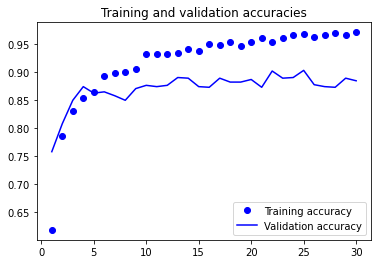

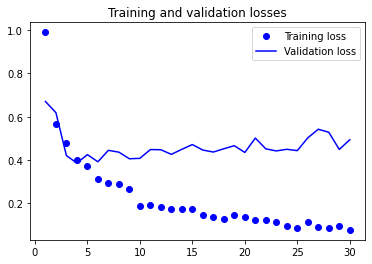

In [37]:
# write your code


### Predicting the test set

Apply now your network to the test set

In [38]:
# write your code


Report the accuracy as well as the classification report. Use sklearn functions

In [39]:
# write your code


Pretrained CNN with augmented images VGG
Class indices {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}
Classification report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       175
           1       0.94      0.93      0.93       203
           2       0.85      0.92      0.88       158
           3       0.95      0.93      0.94       140
           4       0.92      0.89      0.91       189

    accuracy                           0.92       865
   macro avg       0.92      0.92      0.92       865
weighted avg       0.92      0.92      0.92       865

sklearn accuracy: 0.915606936416185


Print the confusion matrix

In [40]:
# write your code


Confusion matrix
[[160   8   3   1   3]
 [  5 189   3   3   3]
 [  4   1 145   1   7]
 [  3   3   3 130   1]
 [  2   1  16   2 168]]


Finally, run a model evaluation and store the loss and accuracy in the `test_loss_4` and `test_acc_4` variables. As with fitting, you may need to adjust the number of steps so that your network tests all the samples.

In [41]:
# Write your code


865/865 [==============================] - 18s 21ms/step - loss: 0.3596 - acc: 0.9156
Epochs 30
loss 0.3596470057964325 test acc: 0.9156069159507751


## Passing the Assignment

To pass the assignment, you need to reach an accuracy of 75 (even 80 ideally) with your best network.

In [42]:
(test_loss_1, test_acc_2), (test_loss_2, test_acc_2), (test_loss_3, test_acc_3), (test_loss_4, test_acc_4)

((4.041093349456787, 0.684393048286438),
 (3.537476062774658, 0.684393048286438),
 (1.950987696647644, 0.8323699235916138),
 (0.3596470057964325, 0.9156069159507751))

## Report

You will write a short report of about two pages on your experiments:
1. You will describe the architectures you designed and the results you obtained;
2. You will run Chollet's notebook 5.4 and read the article <i>Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization</i> by Selvaraju et al. From this, you will reformulate and comment the paragraph on <i>Visualizing heatmaps of class activation</i> in the notebook. You will run it on one of your images.

To write the report, you will use Overleaf.com. The submission procedure is described here: http://cs.lth.se/edan95/lab-programming-assignments/, but send me the Overleaf link only. (PROCEDURE TO BE UPDATED)
<!--<p>    and you will send the link to your report
to the course address: edan95@cs.lth.se. Do not send the PDF, only the link. You will include
the assignment number in the message object.</p>-->
You must submit this report no later than one week after you have completed the lab.